# Analysis of Weather in Athens for the period 1955 - 2020
* This is a project created in the context of the course: "Applied Machine Learning".
* Data are obtained from:
    1. The National Oceanic and Atmospheric Administration's National Centers for Environmental Information (https://www.ncdc.noaa.gov/cdo-web/)
    2. The Helenic Data Service (https://hellenicdataservice.gr/main/)
* The analysis will be done on [Jupyter](http://jupyter.org/).
---
> Georgios Sideris <br />
> geosideris@aueb.gr

## Import packages
* To begin with, we will import the packages that we will use in the following segments of the project:
    * [NumPy](https://www.numpy.org/)
    * [pandas](https://pandas.pydata.org/)
    * [matplotlib](https://matplotlib.org/)
* Note the the prementioned packages **must be locally installed too** in order to be used.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Obtain the Data
* The data used for the analysis can be found in the folder <code>data</code>:
    * <code>data/hellinikon_noaa.csv</code>: contains the data downloaded from [NOAA](https://www.ncdc.noaa.gov/cdo-web/).
    * <code>data/athens_hds.csv</code>: contains the data downloaded from [HDS](https://hellenicdataservice.gr/main/).
* We will talk more about them in the following part.


### Data from NOAA
* The data downloaded from the National Oceanic and Atmospheric Administration's National Centers for Environmental Information refer to the weather station of **Hellinikon** and the period **1955 - 2020**.
* To get them, the search feature of the NOAA website was used (https://www.ncdc.noaa.gov/cdo-web/search).
* Specifically, the filters used were:
    1. Dataset: *Daily Summaries*
    2. Date range: *1955-01-01 to 2020-12-31*
    3. Search for: *Stations*
    4. Search Term: *Hellinikon*  
* The station selected for the download is: *HELLINIKON, GR*
* The output format chosen is: *Custom GHCN-Daily CSV*
* Units were set to: *Metric* (in order to get the data in Celsius and millimeters instead of Fahrenheit and inches)
* Lastly the data types for custom output chosen are:
    1. Precipitation (PRCP) 
    2. Average Temperature (TAVG)
    3. Maximum temperature (TMAX)
    4. Minimum temperature (TMIN)
* The downloaded file was renamed to <code>hellinikon_noaa.csv</code> and can be found at the <code>data</code> folder.

#### Dataset from NOAA
* Next we will generate a dataframe using the <code>data/hellinikon_noaa.csv</code> file.

In [5]:
data_hellinikon_noaa = "data/hellinikon_noaa.csv"
noaa_data = pd.read_csv(data_hellinikon_noaa,
                        parse_dates=["date"], 
                        usecols = range(2, 7), 
                        header=0, 
                        names=["date", "prcp", "avg_temp", "max_temp", "min_temp"])
noaa_data.head(5)

,date,prcp,avg_temp,max_temp,min_temp
0,1955-01-01,0.0,NaN,18.5,10.2
1,1955-01-02,2.0,NaN,14.4,7.0
2,1955-01-03,0.0,NaN,15.8,9.6
3,1955-01-04,0.0,NaN,18.8,7.3
4,1955-01-05,0.0,NaN,17.9,8.4


### Data from HDS
* The data from the Helenic Data Service refer to the weather station of **Athens** and the period **2010-2019**.
* The relative file (**athens.csv**) can be found [here](https://data.hellenicdataservice.gr/dataset/66e1c19a-7b0e-456f-b465-b301a1130e3f).
* The downloaded file was renamed to <code>athens_hds.csv</code> and can be found at the <code>data</code> folder.

#### Dataset from HDS
* Next we will generate a dataframe using the <code>data/athens_hds.csv</code> file.
* The particular file contains information that we are not interested in (documentation can be found [here](https://data.hellenicdataservice.gr/dataset/66e1c19a-7b0e-456f-b465-b301a1130e3f/resource/a7c024b3-8606-4f08-93e2-2042f5bd6748), so we will choose only the columns that refer to the *date*, the *average temperature* and the *precipitation* of each day.

In [15]:
data_athens_hds = "data/athens_hds.csv"
hds_data = pd.read_csv(data_athens_hds,
                       usecols=[0, 1, 10],
                       parse_dates=["date"],
                       names=["date", "avg_temp", "prcp"])
hds_data.head(5)

,date,avg_temp,prcp
0,2010-01-01,17.9,0.2
1,2010-01-02,15.6,0.0
2,2010-01-03,13.5,0.0
3,2010-01-04,9.5,0.0
4,2010-01-05,13.4,0.0


## Explore completeness of data
* Before using the generated dataframes we have to clean, explore and complete them.

### Clean
* A first issue, is the fact that the data from HDS contain dashes ("---"), for missing values, instead of empty cells.

In [9]:
hds_data.dtypes

date        datetime64[ns]
avg_temp            object
prcp               float64
dtype: object

* We can see that the <code>avg_temp</code> column was identified as of object type, instead of float64 (like <code>prcp</code>).
* So, we will replace the dashes with <code>nan</code> values and turn the avg_temp column to float.

In [18]:
hds_mapping = {"---": float("nan")}
hds_data["avg_temp"] = hds_data["avg_temp"] \
                       .map(lambda x : hds_mapping.get(x, float(x) if x != "---" else None)) # get(x, float(x)) raises exception
hds_data.dtypes

date        datetime64[ns]
avg_temp           float64
prcp               float64
dtype: object

* Now the types of the columns look good.

In [19]:
noaa_data.dtypes

date        datetime64[ns]
prcp               float64
avg_temp           float64
max_temp           float64
min_temp           float64
dtype: object

* The types of the NOAA dataframe are also good.

* Another potential problem could be the existence of duplicate dates.
* Let's check it!

In [21]:
noaa_dates = noaa_data["date"]
hds_dates = hds_data["date"]
noaa_dates.duplicated().sum(), hds_dates.duplicated().sum()

(0, 0)

* That's great! We don't have duplicate dates.
* Now our data look clean, but are they complete?

### Explore
* Next we will check if there are **missing dates** or **missing values** from the existing dates.
* The <code>noaa_data</code> dataframe will be used as basis, while <code>hds_data</code> will be used as complement.

#### Missing dates

In [24]:
all_dates = pd.date_range(start='1955-01-01', end='2020/12/31') # a DateTimeIndex of all the days between 1/1/1955 and 31/12/20
len(all_dates)-len(noaa_dates)

856

* It seems like 856 days from the noaa_data_set are missing.
* Let's explore more.

In [26]:
noaa_missing_dates = all_dates[~all_dates.isin(noaa_dates)]
noaa_missing_dates_df = pd.DataFrame(noaa_missing_dates, columns=["date"])
noaa_missing_dates_df.groupby(noaa_missing_dates_df["date"].dt.year).size()

date
2006      2
2007      1
2012    206
2013    355
2014    267
2016      1
2017     23
2018      1
dtype: int64

* Looks like almost all the missing dates are from the period 2012-2018.
* <code>hds_data</code> dataframe comes in handy, as we can use it to fill the missing days.
* But, are there any missing dates from <code>hds_data</code>? 

In [28]:
dates_2010_2019 = pd.date_range(start='2010-01-01', end='2019/12/31') # a DateTimeIndex of all the days between 1/1/2010 and 31/12/2019
len(dates_2010_2019)-len(hds_dates)

0

* There isn't a day missing from <code>hds_data</code>, so we can complete our data using it.

#### Missing values
* It is necessary to also get an idea of the values that are missing from the dates that already exist in <code>noaa_data</code>.

In [29]:
noaa_data["prcp"].isnull().sum(), noaa_data["avg_temp"].isnull().sum()

(478, 2311)

* It looks like there are missing values.
* Let's have an indication of how many of them can be completed using <code>hds_data</code>.
* For that purpose we will calculate the missing values from the period 2010-2019 (of course from the existing dates in <code>noaa_data</code>).

In [32]:
(noaa_data["date"].dt.year.isin(range(2010, 2020)) & noaa_data["prcp"].isnull()).sum(), \
(noaa_data["date"].dt.year.isin(range(2010, 2020)) & noaa_data["avg_temp"].isnull()).sum()

(102, 0)

* Most of the missing values cannot be filled from <code>hds_data</code>.
* Especially, there are a lot of empty cells of *average temperature* (<code>avg_temp</code>).
* An interesting idea is to use the average of the max and min temperature and use it as the average temperature of the day.
* In order to apply that, we have to answer 2 questions:
    1. How many fields of average temperature can be filled in this way?
    2. And more importantly, how good estimation of the average temperature, the average(<code>min_temp</code>, <code>max_temp</code>) is?

* The first question can be easily answered.

In [34]:
calculatable_avg_temp = ( \
 ~ (noaa_data["max_temp"].isnull()) & \
 ~ (noaa_data["min_temp"].isnull()) & \
 (noaa_data["avg_temp"].isnull()) \
                        )

calculatable_avg_temp.sum() # the number of days with missing avg_temp but with available  max and min temp

2310

* The average temperature for almost every date can be filled if we choose to proceed with the application of this idea!
* But, we have to answer the second prementioned question.
* To do this we will execute a very simple statistical analysis. 
* **BUT**, it is important to note if the decision of using the average(<code>max_temp</code>, <code>min_temp</code>) is critical a further and more accurate analysis must be used.

In [37]:
# rows of the noaa dataset with no temperature field missing (avg_temp, max_temp, min_temp all not null)
noaa_data_full_temp = noaa_data[~ noaa_data.avg_temp.isnull() & \
                                ~ noaa_data.max_temp.isnull() & \
                                ~ noaa_data.min_temp.isnull()].copy()
print(len(noaa_data_full_temp))
noaa_data_full_temp["avg_min_max_temp"] = round((noaa_data_full_temp["min_temp"] + noaa_data_full_temp["max_temp"])/2, 1)

diff_of_avgs = noaa_data_full_temp["avg_temp"] - noaa_data_full_temp["avg_min_max_temp"]
diff_of_avgs.mean(), diff_of_avgs.std()

19372


(-0.12309518893247984, 0.7169931309904884)

* In the previous snipet of code, firstly, we created a view of the days that all min, max and average temperatures are available.
* Then, we calculated the difference: <code>avg_temp</code> - average(<code>max_temp</code>, <code>min_temp</code>)
* After, we found the mean and the standard deviaton of this difference.
* What conclusion can we make?
    * The mean found is only -0.12, with a standard deviation of less that a Celsius degree.
    * Also, the number of observations that we used is relatively large (19372).
    * As a result, we conclude that the average of the max and min temperature provide a very good estimation of the average temperature of a day, **in the context of the particular analysis**.

### Complete
* After our exploration of the data, we identified that in order to complete our data we have to:
    1. Fill the missing dates of <code>noaa_data</code>, from <code>hds_data</code>.
    2. Fill the missing precipitations from the existing dates of <code>noaa_data</code>, from <code>hds_data</code>.
    3. Fill the missing average temperatures of <code>noaa_data</code> using the average of max and min temperature.

* Initially, let's join <code>noaa_data</code> and <code>hds_data</code>.  

**It is crucial to mention a hypothesis that we do for this analysis: we assume that the data of the two sources refer to the same location.** Even though, we know that they are gotten from different weather stations, they are close enough, that it is rational to assume that the differences are insignificant.

In [38]:
full_data = pd.merge(noaa_data, hds_data, how = "outer", on = "date", suffixes=('_noaa', '_hds')) # outer is used in order to 
                                                                                                  # also get the missing dates
full_data = full_data.sort_values(by = ["date"]) # after adding the new data our data are not in chronological order
full_data = full_data.reset_index(drop = True) # reset the index after reordering the rows
full_data[full_data["date"].dt.year.isin(range(2010, 2020))].head(5)

,date,prcp_noaa,avg_temp_noaa,max_temp,min_temp,avg_temp_hds,prcp_hds
20086,2010-01-01,NaN,18.0,21.8,NaN,17.9,0.2
20087,2010-01-02,0.0,16.0,17.8,13.8,15.6,0.0
20088,2010-01-03,0.0,13.5,15.6,10.8,13.5,0.0
20089,2010-01-04,0.0,8.9,11.0,5.8,9.5,0.0
20090,2010-01-05,0.0,13.1,16.0,8.6,13.4,0.0


* Next, we will create a new column for precipitation, that we will contain:
    * <code>prcp_noaa</code> if it is not <code>NaN</code>.
    * <code>prcp_hds</code> if it is not <code>Nan</code> and <code>prcp_noaa</code> is <code>NaN</code>.
    * <code>NaN</code> in different case.

In [39]:
full_data["prcp"] = full_data["prcp_noaa"].fillna(full_data["prcp_hds"])
full_data[full_data["date"].dt.year.isin(range(2010, 2020))].head(5)

,date,prcp_noaa,avg_temp_noaa,max_temp,min_temp,avg_temp_hds,prcp_hds,prcp
20086,2010-01-01,NaN,18.0,21.8,NaN,17.9,0.2,0.2
20087,2010-01-02,0.0,16.0,17.8,13.8,15.6,0.0,0.0
20088,2010-01-03,0.0,13.5,15.6,10.8,13.5,0.0,0.0
20089,2010-01-04,0.0,8.9,11.0,5.8,9.5,0.0,0.0
20090,2010-01-05,0.0,13.1,16.0,8.6,13.4,0.0,0.0


* We will follow the corresponding procedure for the average temperature.
* In the new column we will collect the average temperatures from <code>noaa_data</code>, but also the average temperatures from <code>hds_data</code> for the dates that were missing from <code>noaa_data</code>.

In [40]:
full_data["avg_temp"] = full_data["avg_temp_noaa"].fillna(full_data["avg_temp_hds"])
full_data[full_data["date"].dt.year.isin(range(2010, 2020))].head(5)

,date,prcp_noaa,avg_temp_noaa,max_temp,min_temp,avg_temp_hds,prcp_hds,prcp,avg_temp
20086,2010-01-01,NaN,18.0,21.8,NaN,17.9,0.2,0.2,18.0
20087,2010-01-02,0.0,16.0,17.8,13.8,15.6,0.0,0.0,16.0
20088,2010-01-03,0.0,13.5,15.6,10.8,13.5,0.0,0.0,13.5
20089,2010-01-04,0.0,8.9,11.0,5.8,9.5,0.0,0.0,8.9
20090,2010-01-05,0.0,13.1,16.0,8.6,13.4,0.0,0.0,13.1


* Then we will add in the newly created <code>avg_temp</code> column the average(<code>max_temp</code>, <code>min_temp</code>) for the missing <code>avg_temp</code> values.

In [43]:
# we have to recalculate calculateble_avg_temp after the merge
calculatable_avg_temp = ( \
 ~ (full_data["max_temp"].isnull()) & \
 ~ (full_data["min_temp"].isnull()) & \
 (full_data["avg_temp_noaa"].isnull()) \
                        )
                         
full_data["avg_temp"] = full_data["avg_temp"].where(~ calculatable_avg_temp, (full_data["max_temp"] + full_data["min_temp"]) /2)

* We will create a copy of <code>full_data</code> dataframe that will contain only the columns that are useful for our analysis.
* This will be the dataframe that we will work on.

In [47]:
df = full_data[["date", "prcp", "avg_temp"]].copy()
df.head(5)

,date,prcp,avg_temp
0,1955-01-01,0.0,14.35
1,1955-01-02,2.0,10.70
2,1955-01-03,0.0,12.70
3,1955-01-04,0.0,13.05
4,1955-01-05,0.0,13.15


### Overview of data
* Let's calculate again some characteristics of our data after completing them.

In [48]:
print("missing dates:", len(all_dates) - len(df))
print("missing average temperatures:", df["avg_temp"].isnull().sum())
print("missing precipitations:", df["prcp"].isnull().sum())

missing dates: 3
missing average temperatures: 2
missing precipitations: 376


#### Looks like our data are much more complete now and we can move on with our analysis!

## Deviation of Summer Temperatures
* Beginning our analysis we will calculate the mean summer temperature deviation from a baseline of 1974-1999 and we will create the corresponding graph.
* An identical graph can be found in page 7 of the [report on extreme events](http://www.hnms.gr/emy/en/pdf/2020_GRsignificantEVENT_en.pdf) of the Hellenic National Meteorological Service.

* A column with the year of each row will be useful afterwards.

In [49]:
df["year"] = df["date"].dt.year

* Then we will generate a view of the dataframe that contains only the summer days (by summer day we mean every day of June, July and August).

In [50]:
summerdays = df[df["date"].dt.month.isin(range(6, 9))]
summerdays.head(5)

,date,prcp,avg_temp,year
151,1955-06-01,0.0,21.8,1955
152,1955-06-02,0.0,21.7,1955
153,1955-06-03,0.0,21.5,1955
154,1955-06-04,0.0,22.7,1955
155,1955-06-05,0.0,22.5,1955


* Now the mean temperature of the summer days within the base period 1974-1999, can be easily calculated.
* This is the baseline temperature that we will use to calculate the deviation.

In [51]:
base_summer_temp = summerdays.loc[summerdays["year"].isin(range(1974, 2000)), "avg_temp"].mean() # summerdays from 1974-1999
base_summer_temp

26.230727424749166

* In order to calculate the average temperature separately for each summer, we will group the summer days of every year.

In [52]:
summers_grouped = summerdays.groupby("year")
for name, summer_group in list(summers_grouped)[:3]:
    print(name)
    print(summer_group[:3])

1955
          date  prcp  avg_temp  year
151 1955-06-01   0.0      21.8  1955
152 1955-06-02   0.0      21.7  1955
153 1955-06-03   0.0      21.5  1955
1956
          date  prcp  avg_temp  year
517 1956-06-01   0.0     20.85  1956
518 1956-06-02   0.0     23.00  1956
519 1956-06-03   0.0     21.70  1956
1957
          date  prcp  avg_temp  year
882 1957-06-01   0.0      21.2  1957
883 1957-06-02   0.0      24.6  1957
884 1957-06-03   0.0      24.8  1957


* Now we need to calculate the average temperature of each summer.

In [53]:
summers_temp = summers_grouped["avg_temp"].mean()
summers_temp.head(5)

year
1955    25.951087
1956    27.143478
1957    27.371739
1958    27.081522
1959    26.401087
Name: avg_temp, dtype: float64

* Having calculated the average temperature of all the summers and also the baseline summer temperature, we can now calculate the deviation from the baseline for each summer.

In [55]:
summers_dev_from_base = summers_temp - base_summer_temp
summers_dev_from_base.head(5)

year
1955   -0.279640
1956    0.912751
1957    1.141012
1958    0.850794
1959    0.170360
Name: avg_temp, dtype: float64

* Additionally, it would be nice if we added to our graph a line, representing the 10 years rolling avarege of the deviation from the mean.
* In this way we will get a better picture of extreme events.

In [56]:
summers_roll_avg_dev = summers_dev_from_base.rolling(10, min_periods=1).mean()

* Now it is time to plot our graph!

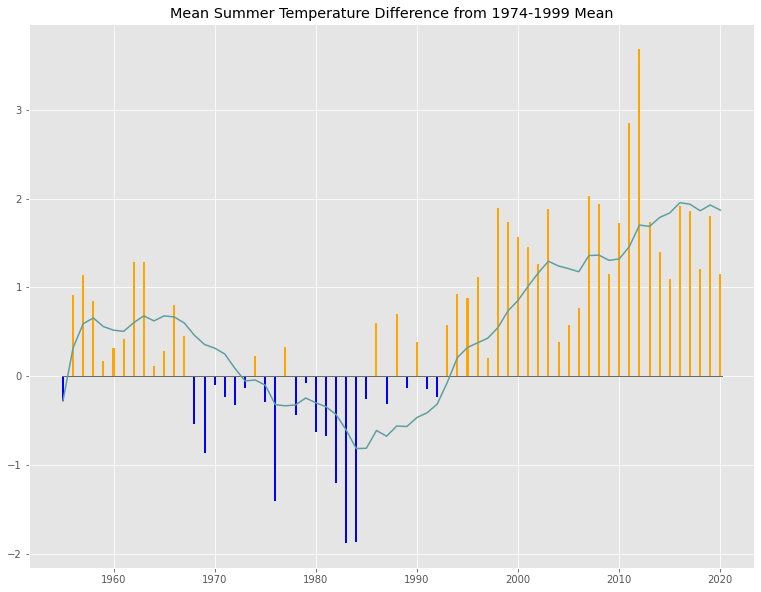

In [57]:
plt.style.use('ggplot')
plt.figure(figsize=(13, 10))
plt.title("Mean Summer Temperature Difference from 1974-1999 Mean")
plt.bar(summers_dev_from_base.index, 
        summers_dev_from_base, 
        width = 0.2, 
        color=np.where(summers_dev_from_base < 0, 'blue', 'orange'),
        )
plt.axhline(xmin = 0.045, xmax = 0.955, color = "dimgrey", linewidth = 1) # for the line on the x axis
plt.plot(summers_roll_avg_dev.index, summers_roll_avg_dev, color = "cadetblue")

### Interpretation
* The mean summer temperature fluctuated at relatively low levels in the period 1955-1995, and especially within 1964-1993.
* In the period 1996-2020 the mean summer temperature is almost every year a degree higher than the baseline temperature.
* Generally, the trend is upwards.
* A  relative steadiness can be noted in the period 2014-2020.

All the above observations can be explained by the increased human activity the latter years. The combustion of fuels and deforastation are only few causes of the problem. A positive insight is that the efforts against global change seem to yield results,  